In [1]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import torch
from torch import Tensor
from torch_geometric.nn import GCNConv

import pandas as pd
from tqdm.auto import trange
import numpy as np

e:\anaconda\envs\study\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Задание 3

- [+] Найти графовый набор данных для решения задачи предсказания (классификация вершин, обнаружение сообществ и т.д.).
- [+] Использовать несколько слоев `GCNConv` из библиотеки `PyG` для построения GCN модели.
- [+] Обучить полученную модель, подобрать гиперпараметры (например, learning rate) на валидационной выборке, и оценить качество предсказания на тестовой выборке.
- [+] (+5 баллов) Также представить самостоятельную реализацию слоя `GCNConv`, используя матричные операции. Повторить обучение с собственными слоями и сравнить результаты.

In [2]:
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

# Данные

Возьмем небольшой набор данных, чтобы можно было запустить на локальном компьютере

In [3]:
dataset = Planetoid(root='data/Planetoid', name='CiteSeer', transform=NormalizeFeatures())

In [4]:
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Dataset: CiteSeer():
Number of graphs: 1
Number of features: 3703
Number of classes: 6

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])
Number of nodes: 3327
Number of edges: 9104
Average node degree: 2.74
Number of training nodes: 120
Training node label rate: 0.04
Has isolated nodes: True
Has self-loops: False
Is undirected: True


In [5]:
class GCN(torch.nn.Module):
	def __init__(self, dataset, size_emb, conv_type=GCNConv):
		super().__init__()
		torch.manual_seed(123456)
		self.conv1 = conv_type(dataset.num_features, size_emb*2)
		self.conv2 = conv_type(size_emb*2, size_emb)
		self.conv3 = conv_type(size_emb, dataset.num_classes)

	def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
		x = self.conv1(x, edge_index).relu()
		x = self.conv2(x, edge_index).relu()
		x = self.conv3(x, edge_index)
		return x

In [6]:
def train(data, model, optimizer, criterion):
	model.train()
	optimizer.zero_grad()  # Clear gradients.
	out = model(data.x, data.edge_index)  # Perform a single forward pass.
	loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
	loss.backward()  # Derive gradients.
	optimizer.step()  # Update parameters based on gradients.
	return loss

def validate(data, model):
  model.eval()
  out = model(data.x, data.edge_index)
  val_pred = out.argmax(dim=1)  # Use the class with highest probability.
  test_correct = val_pred[data.val_mask] == data.y[data.val_mask]  # Check against ground-truth labels.
  test_acc = int(test_correct.sum()) / int(data.val_mask.sum())  # Derive ratio of correct predictions.
  return test_acc

def test(data, model):
	model.eval()
	out = model(data.x, data.edge_index)
	pred = out.argmax(dim=1)  # Use the class with highest probability.
	test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
	test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
	return test_acc

Подбор параметров

In [7]:
data_grid = {
    'lr': [],
	'size_emb': [],
    'accuracy': [],
	}

lrs = [0.1, 0.01, 0.001]
size_embs = [4, 8, 16, 32]

criterion = torch.nn.CrossEntropyLoss()

for lr in lrs:
	for size_emb in size_embs:
		data_grid['lr'].append(lr)
		data_grid['size_emb'].append(size_emb)

		model = GCN(dataset, size_emb=size_emb)
		optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)

		epoch_pbar = trange(0, 100)
		for epoch in epoch_pbar:
			loss = train(data, model, optimizer, criterion)
			epoch_pbar.set_description(f'LR: {lr}, size_emb: {size_emb}, Epoch {epoch:03d}, loss: {loss:.4f}')

		val_acc = validate(data, model)
		data_grid['accuracy'].append(val_acc)

LR: 0.001, size_emb: 32, Epoch 099, loss: 0.9678: 100%|██████████| 100/100 [00:03<00:00, 29.41it/s]


In [8]:
data_grid = pd.DataFrame(data_grid).sort_values(by=['accuracy'], ascending=False)
data_grid

,lr,size_emb,accuracy
11,0.001,32,0.680
7,0.010,32,0.660
6,0.010,16,0.658
3,0.100,32,0.652
1,0.100,8,0.616
2,0.100,16,0.600
5,0.010,8,0.558
9,0.001,8,0.508
10,0.001,16,0.502
0,0.100,4,0.466


**Вывод**: В итоге перебора параметров модели лучшая с `lr=0.01` и `size_emb=32`

In [9]:
lr = 0.001
size_emb = 32
epoch = 200
criterion = torch.nn.CrossEntropyLoss()
model = GCN(dataset, size_emb=size_emb)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)

losses = []
epoch_pbar = trange(0, 200)
for epoch in epoch_pbar:
	loss = train(data, model, optimizer, criterion)
	losses.append(loss.item())
	epoch_pbar.set_description(f'Epoch {epoch:03d}, loss: {loss:.4f}')

Epoch 199, loss: 0.3021: 100%|██████████| 200/200 [00:07<00:00, 26.20it/s]


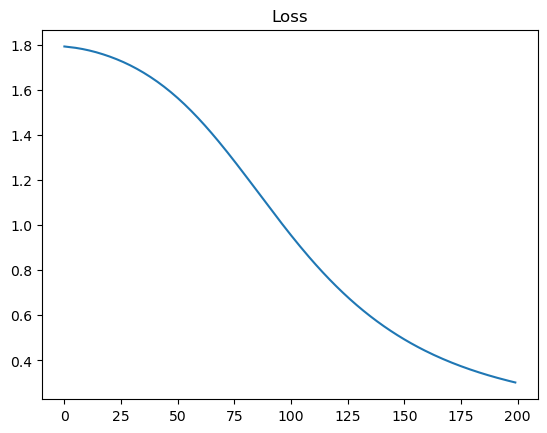

In [10]:
plt.plot(np.arange(len(losses)), losses)
plt.title('Loss')
plt.show()

In [11]:
val_acc = validate(data, model)
print(f'Val accuracy: {val_acc:.4f}')

Val accuracy: 0.6820


In [12]:
test_acc = test(data, model)
print(f'Test accuracy: {val_acc:.4f}')

Test accuracy: 0.6820


# Визуализация графа, после обучения

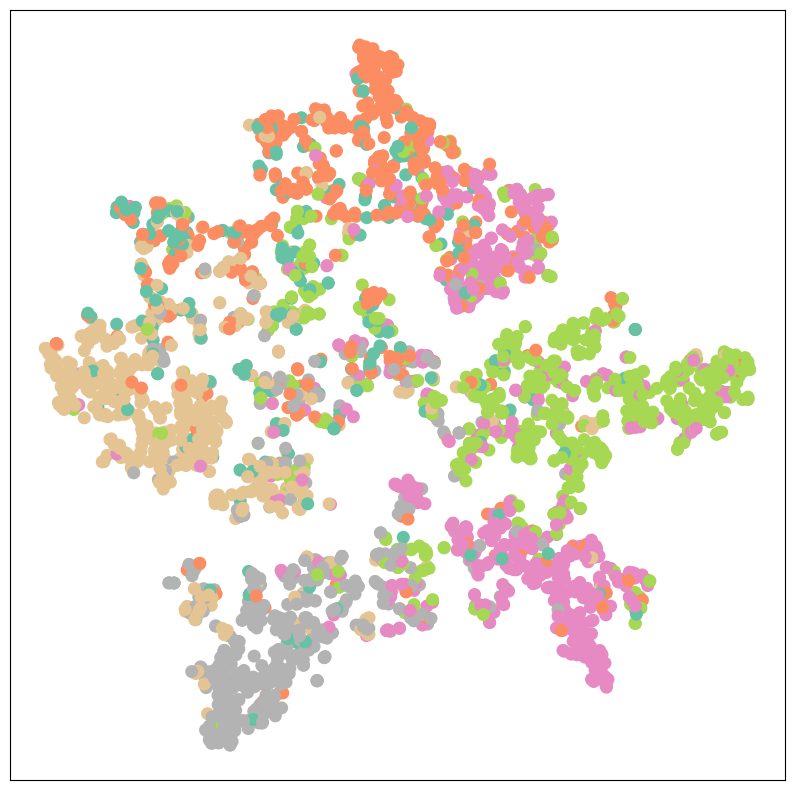

In [13]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

**Вывод:** можно отметить, что модель сумела выделить несколько классов и они разделимы визуально, но также есть точки, которые плохо классифицируются и находятся внутри других классов

# Собственный слой GCN

In [19]:
import torch.nn as nn
import math


class GraphConvLayer(nn.Module):
	"""Graph Convolutional Layer, основанный на https://arxiv.org/pdf/1609.02907"""

	def __init__(self, in_features, out_features):
		super().__init__()
		self.W = nn.Parameter(torch.FloatTensor(in_features, out_features))
		self.bias = nn.Parameter(torch.FloatTensor(out_features))
		self.in_features = in_features
		self.out_features = out_features

		self.reset_parameters()

	def reset_parameters(self):
		# инициализация весов из равномерного распределения (https://github.com/pytorch/pytorch/issues/57109)
		nn.init.kaiming_uniform_(self.W, a=math.sqrt(5))
		# инициализация баеса из нормального распределения 
		nn.init.normal_(self.bias)
		
	def _laplassian(self, A):
		# Добавим единичную матрицу к матрице рёбер
		A = A + torch.eye(A.shape[0])
		# Вычислим степени вершин
		D = torch.eye(A.shape[0]) * torch.sum(A, dim=0)
		# Вычислим Лаплассиан
		D_sqrt = torch.linalg.inv(torch.sqrt(D))
		L = D_sqrt @ A @ D_sqrt

		return L
	
	def _edge_index_unwrap(self, A, num_nodes):
		A_unwarp = torch.zeros(num_nodes, num_nodes)
		A_unwarp[A.T] = 1
		A_unwarp += A_unwarp.T.clone()  # т.к. граф не ориентированный
		return A_unwarp

	def forward(self, X, A):
		# Преобразуем ребра в матрицу связей
		if A.shape[0] == 2 and A.shape[1] != 2:
			A = self._edge_index_unwrap(A, X.shape[0])
		assert X.shape[0] == A.shape[0] == A.shape[1]
		# Преобразуем размерность x (N, C) в размерность скрытого состояния (N, F)
		X = X @ self.W # перемножение матриц
		# Найдём Лаплассиан
		L = self._laplassian(A)
		output = L @ X
		output = output + self.bias
		return output
	

**Вывод**: В итоге перебора параметров модели лучшая с `lr=0.01` и `size_emb=32`

In [20]:
lr = 0.001
size_emb = 32
epoch = 200
criterion = torch.nn.CrossEntropyLoss()
model = GCN(dataset, size_emb=size_emb, conv_type=GraphConvLayer)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)

losses = []
epoch_pbar = trange(0, 50)
for epoch in epoch_pbar:
	loss = train(data, model, optimizer, criterion)
	losses.append(loss.item())
	epoch_pbar.set_description(f'Epoch {epoch:03d}, loss: {loss:.4f}')

Epoch 049, loss: 1.8322: 100%|██████████| 50/50 [03:16<00:00,  3.92s/it]


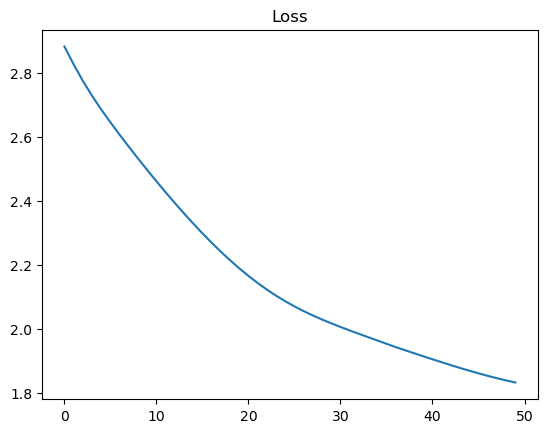

In [21]:
plt.plot(np.arange(len(losses)), losses)
plt.title('Loss')
plt.show()

In [22]:
val_acc = validate(data, model)
print(f'Val accuracy: {val_acc:.4f}')

Val accuracy: 0.2320


In [23]:
test_acc = test(data, model)
print(f'Test accuracy: {val_acc:.4f}')

Test accuracy: 0.2320


**Вывод:** Собственная реализация работает достаточно медленно вероятнее всего, что лаплассиян вычисляется не эффективно.Также медленное снижение loss связано с тем, что в реализации torch_geometric используется линейный слой для перевода входов скритого состояния, а не обучаемые веса, как в собственной реализации.
Также можно увидеть, что точность в разы ниже.